# Seoul Bike Trip Duration Prediction

<img src="Features_Description.png" style="float:right;" width="500"/>

### Context
- Trip duration is the most fundamental measure in all modes of transportation. 
- Hence, it is crucial to predict the trip-time precisely for the advancement of Intelligent Transport Systems (ITS) and traveller information systems. 
- In order to predict the trip duration, data mining techniques are employed in this paper to predict the trip duration of rental bikes in Seoul Bike sharing system. 
- The prediction is carried out with the combination of Seoul Bike data and weather data.

### Content
- The Data used include trip duration, trip distance, pickup-dropoff latitude and longitude, 
temperature, precipitation, wind speed, humidity, solar radiation, snowfall, ground temperature and 1-hour average dust concentration.

### Acknowledgements
- V E, Sathishkumar (2020), "Seoul Bike Trip duration prediction", Mendeley Data, V1, doi: 10.17632/gtfh9z865f.1
- Sathishkumar V E, Jangwoo Park, Yongyun Cho, (2019), Seoul bike trip duration prediction using data mining techniques, IET Intelligent Transport Systems, doi: 10.1049/iet-its.2019.0796

### Goal
- Predict the trip duration

### Steps
- Exploratory Data Analysis (EDA)
- Data Preprocessing
- Feature Selection / Transformation
- **Mahcine Learning Algorithm**
- **Feature Importance / Engineering**
- **Hyperparameter Tuning**
- **Explainable AL/ML**
- Model Deployment

## Load libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from helper_functions import *

from timeit import default_timer as timer

## Data

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, X_test, y_train, y_val, y_test = \
joblib.load('data/X_train.pkl'),\
joblib.load('data/X_val.pkl'),\
joblib.load('data/X_test.pkl'),\
joblib.load('data/y_train.pkl'),\
joblib.load('data/y_val.pkl'),\
joblib.load('data/y_test.pkl')

rfe_features = X_train.columns

train_dataset = X_train.copy()
train_dataset['Duration'] = y_train

In [4]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((3964624, 10), (495578, 10), (495579, 10), (3964624,), (495578,), (495579,))

In [26]:
train_dataset

,Distance,Haversine,Phour,Pmin,Dhour,Dmin,Temp,Humid,Solar,Dust,Duration
71152,1110,0.711671,17,23,17,29,4.8,38.0,0.47,64.0,5
3611655,2600,1.159844,17,57,18,13,24.3,31.0,1.17,22.0,14
52753,2200,0.847054,13,49,14,42,-1.3,35.0,1.18,62.0,52
4716811,4370,3.123298,8,26,8,49,2.0,84.0,0.03,59.0,22
3867208,3600,2.344361,9,36,9,50,12.2,51.0,1.02,20.0,14
...,...,...,...,...,...,...,...,...,...,...,...
4457994,400,0.368593,8,50,8,53,11.3,89.0,0.01,94.0,3
2541668,2290,1.545385,19,14,19,28,33.5,54.0,0.35,21.0,13
250565,8490,3.400058,19,14,20,12,8.8,49.0,0.05,27.0,55
229772,1860,1.380952,8,29,8,42,3.8,56.0,0.32,14.0,12


### Feature scaling

In [6]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_val = scalar.transform(X_val)
X_test = scalar.transform(X_test)

joblib.dump(scalar, 'models/scalar.joblib')

['models/scalar.joblib']

## Machine Learning Algorithms

In [7]:
def fit_ML_model(modelName, model, error=pd.DataFrame(
    [], index=['Train Loss','Val Loss', 'Test Loss', 'y_mean','Time (s)'])):

    from sklearn.metrics import mean_squared_error
    
    start = timer()
    
    model.fit(X_train, y_train)
    rmse_train = mean_squared_error(y_train, model.predict(X_train))**0.5
    rmse_val = mean_squared_error(y_val, model.predict(X_val))**0.5
    rmse_test = mean_squared_error(y_test, model.predict(X_test))**0.5

    end = timer()

    error[modelName] = [rmse_train, rmse_val, rmse_test, y_train.mean(), end-start]

    return model, error

###  Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression

modelName = 'LinReg'
lr, error = fit_ML_model(modelName, LinearRegression())

feature_importances = pd.DataFrame(abs(lr.coef_), index=rfe_features, columns=[modelName])
feature_importances[modelName] /= feature_importances[modelName].max()

joblib.dump(lr, 'models/LinReg.pkl', compress=3)

error

,LinReg
Train Loss,4.145283
Val Loss,3.886713
Test Loss,4.274747
y_mean,20.644918
Time (s),2.789263


### Random Forest

In [9]:
from sklearn.ensemble import RandomForestRegressor

modelName = 'RandForest'
rf = RandomForestRegressor(n_estimators=100, min_samples_split=5, n_jobs=-1)
rf, error = fit_ML_model(modelName, rf)

feature_importances[modelName] = rf.feature_importances_
feature_importances[modelName] /= feature_importances[modelName].max()

joblib.dump(rf, 'models/RandForest.joblib', compress=3)

error

,LinReg,RandForest
Train Loss,4.145283,1.602342
Val Loss,3.886713,3.415504
Test Loss,4.274747,3.419786
y_mean,20.644918,20.644918
Time (s),2.789263,547.514429


### XGBoost

In [10]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

modelName = 'XGBoost'
xgb = XGBRegressor(learning_rate=0.3, n_estimators=100, n_jobs=-1,
                   tree_method='exact', eval_set=[(X_val, y_val)], 
                   early_stopping_rounds=10, verbose=1)
xgb, error = fit_ML_model(modelName, xgb)

feature_importances[modelName] = xgb.feature_importances_
feature_importances[modelName] /= feature_importances[modelName].max()

joblib.dump(xgb, 'models/XGBoost.joblib', compress=3)

error

[13:53:58] WARNING: ../src/learner.cc:573: 
Parameters: { "early_stopping_rounds", "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,LinReg,RandForest,XGBoost
Train Loss,4.145283,1.602342,3.687873
Val Loss,3.886713,3.415504,3.757414
Test Loss,4.274747,3.419786,3.770613
y_mean,20.644918,20.644918,20.644918
Time (s),2.789263,547.514429,134.070765


### Neural Network

In [11]:
import tensorflow as tf
from tensorflow import keras

nodes = 64
n_hidden = 2
activation = 'relu'

ann = tf.keras.Sequential(keras.layers.Dense(nodes, activation=activation, input_shape=X_train.shape[1:]))

for _ in range(n_hidden-1):  
    ann.add(keras.layers.Dense(nodes, activation=activation))

ann.add(keras.layers.Dense(1))

ann.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                704       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________


In [12]:
epochs = 1000
batch_size = 10000

lr = 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=lr) 
ann.compile(loss='mean_squared_error', optimizer=optimizer)

checkpoint_cb = keras.callbacks.ModelCheckpoint("models/ANN.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

start = timer()
history = ann.fit(X_train, y_train, validation_data=(X_val, y_val), 
                  epochs=epochs, batch_size=batch_size, validation_batch_size=batch_size,
                  callbacks=[checkpoint_cb, early_stopping_cb])

end = timer()

Epoch 1/1000
397/397 [==============================] - 4s 9ms/step - loss: 388.2310 - val_loss: 109.9931
Epoch 2/1000
397/397 [==============================] - 2s 5ms/step - loss: 94.0738 - val_loss: 39.8690
Epoch 3/1000
397/397 [==============================] - 2s 5ms/step - loss: 24.9281 - val_loss: 6.1508
Epoch 4/1000
397/397 [==============================] - 2s 5ms/step - loss: 5.5047 - val_loss: 4.7020
Epoch 5/1000
397/397 [==============================] - 2s 5ms/step - loss: 4.3393 - val_loss: 4.2027
Epoch 6/1000
397/397 [==============================] - 2s 5ms/step - loss: 4.0276 - val_loss: 3.7820
Epoch 7/1000
397/397 [==============================] - 2s 5ms/step - loss: 3.5925 - val_loss: 3.3401
Epoch 8/1000
397/397 [==============================] - 2s 5ms/step - loss: 2.9991 - val_loss: 2.8667
Epoch 9/1000
397/397 [==============================] - 2s 5ms/step - loss: 2.6444 - val_loss: 2.4799
Epoch 10/1000
397/397 [==============================] - 2s 6ms/step - loss

397/397 [==============================] - 2s 5ms/step - loss: 1.4438 - val_loss: 1.4860
Epoch 81/1000
397/397 [==============================] - 2s 5ms/step - loss: 1.4085 - val_loss: 1.4860
Epoch 82/1000
397/397 [==============================] - 2s 5ms/step - loss: 1.4508 - val_loss: 1.4674
Epoch 83/1000
397/397 [==============================] - 2s 5ms/step - loss: 1.4033 - val_loss: 1.4764
Epoch 84/1000
397/397 [==============================] - 2s 5ms/step - loss: 1.4197 - val_loss: 1.4695
Epoch 85/1000
397/397 [==============================] - 2s 5ms/step - loss: 1.4254 - val_loss: 1.4718
Epoch 86/1000
397/397 [==============================] - 2s 5ms/step - loss: 1.4213 - val_loss: 1.4575
Epoch 87/1000
397/397 [==============================] - 2s 5ms/step - loss: 1.4468 - val_loss: 1.4597
Epoch 88/1000
397/397 [==============================] - 2s 5ms/step - loss: 1.3992 - val_loss: 1.4507
Epoch 89/1000
397/397 [==============================] - 2s 5ms/step - loss: 1.4301 - v

In [13]:
# still need to find a good way to determine feature importance using NN --> SHAP (later)
# feature_importances['NN_CPU'] =np.mean(abs(ann.weights[0]), axis=1)

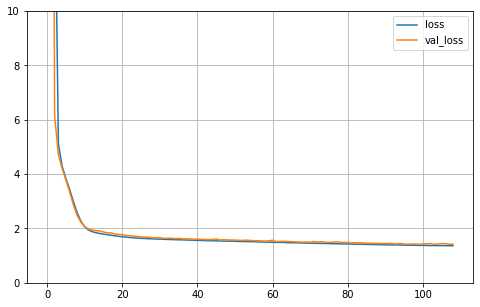

In [14]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 10)
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error

rmse_train = mean_squared_error(y_train, ann.predict(X_train, batch_size=batch_size))**0.5
rmse_val = mean_squared_error(y_val, ann.predict(X_val, batch_size=batch_size))**0.5
rmse_test = mean_squared_error(y_test, ann.predict(X_test, batch_size=batch_size))**0.5
error['NN_CPU'] = [rmse_train, rmse_val, rmse_test, y_train.mean(), end-start]
error

,LinReg,RandForest,XGBoost,NN_CPU
Train Loss,4.145283,1.602342,3.687873,1.168208
Val Loss,3.886713,3.415504,3.757414,1.189576
Test Loss,4.274747,3.419786,3.770613,1.190364
y_mean,20.644918,20.644918,20.644918,20.644918
Time (s),2.789263,547.514429,134.070765,221.045986


### Plotting best results (NN)

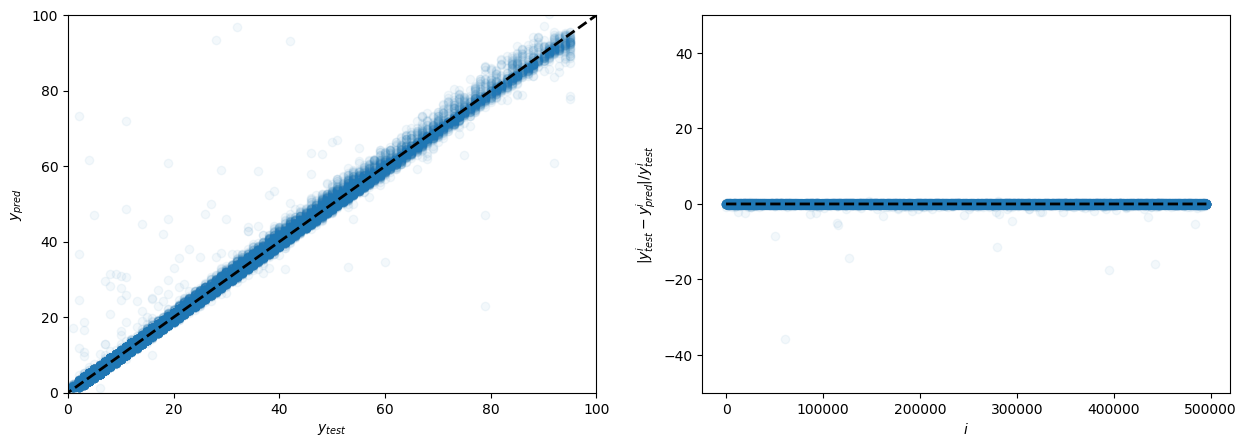

In [16]:
y_pred = ann.predict(X_test, batch_size=batch_size)
rel_res = (y_test.values-y_pred[:,0])/y_test.values

plot_idx = np.random.choice(range(len(y_test)), size=len(y_test)//10, replace=False)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5), dpi=100)

ax[0].scatter(y_test.values[plot_idx], y_pred[:,0][plot_idx], alpha=0.05);
ax[0].set_xlabel('$y_{test}$')
ax[0].set_ylabel('$y_{pred}$')
ax[0].set_xlim(0,100)
ax[0].set_ylim(0,100)
ax[0].plot(range(-10,130), range(-10,130), '--k', lw=2);

ax[1].scatter(np.arange(len(rel_res))[plot_idx], rel_res[plot_idx], alpha=0.05);
ax[1].set_xlabel('$i$')
ax[1].set_ylabel('$|y_{test}^i-y_{pred}^i|/y_{test}^i$');
ax[1].plot(range(len(rel_res)), 0*np.arange(len(rel_res)), '--k', lw=2);
ax[1].set_ylim(-50,50);

# sns.kdeplot(y_test.values-y_pred[:,0], ax=ax[1], shade=True)
# ax[1].set_xlim(-50,50);

## Feature Importance

In [17]:
df_corr = train_dataset.corr()
feature_importances['Duration_Corr'] = df_corr['Duration'].abs().sort_values()[:-1]

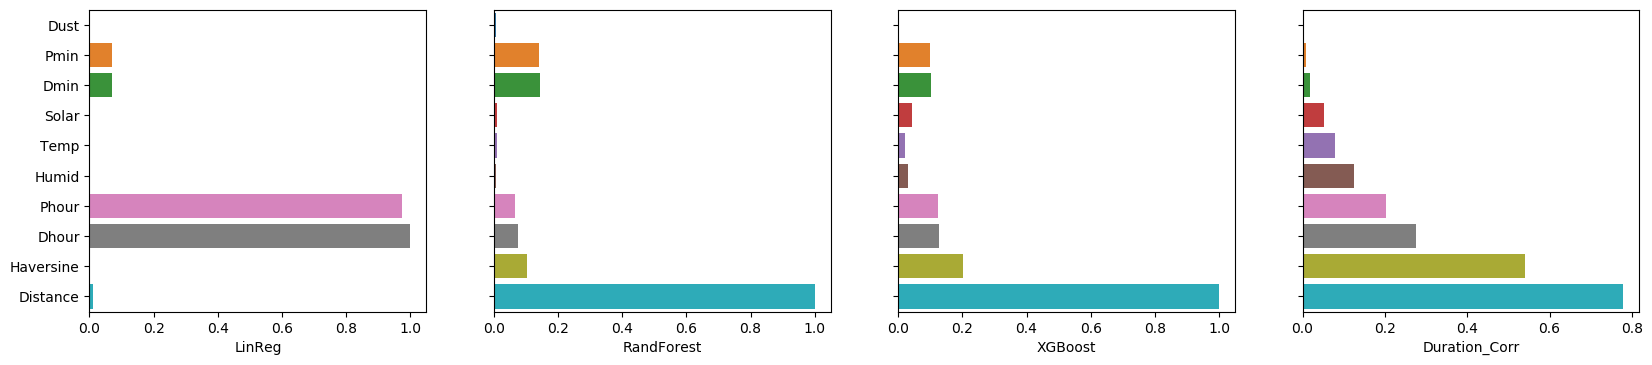

In [18]:
feature_importances = feature_importances.sort_values('Duration_Corr')

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20,4), dpi=100, sharey=True)

sns.barplot(y=feature_importances.index, x= feature_importances.LinReg, ax=ax[0])
sns.barplot(y=feature_importances.index, x= feature_importances.RandForest, ax=ax[1])
sns.barplot(y=feature_importances.index, x= feature_importances.XGBoost, ax=ax[2])
sns.barplot(y=feature_importances.index, x= feature_importances.Duration_Corr, ax=ax[3]);

## Hyperparameters Tuning
Sklearn's ```RandomizedSearchCV``` with ```keras.wrappers.scikit_learn.KerasRegressor(model)```

In [19]:
def build_model(n_hidden=1, n_neurons=16, learning_rate=1e-3, input_shape=[10], activation='relu'): 
    model = keras.models.Sequential() 
    model.add(keras.layers.InputLayer(input_shape=input_shape)) 
    for _ in range(n_hidden): 
        model.add(keras.layers.Dense(n_neurons, activation=activation)) 
    model.add(keras.layers.Dense(1)) 
    optimizer = keras.optimizers.Adam(lr=learning_rate) 
    model.compile(loss="mse", optimizer=optimizer) 
    return model

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [20]:
from sklearn.model_selection import RandomizedSearchCV

epochs = 1000
batch_size = 10000

param_distribs = { 
    "n_hidden": np.arange(1, 6).tolist(), 
    "n_neurons": np.arange(1, 101).tolist(), 
    "learning_rate": np.linspace(3e-4, 3e-2, 100).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=20, cv=3, n_jobs=-1, verbose=1)
start = timer()
rnd_search_cv.fit(X_train, y_train, validation_data=(X_val, y_val), 
                  epochs=epochs, batch_size=batch_size, validation_batch_size=batch_size,
                  callbacks=[keras.callbacks.EarlyStopping(patience=5)])
end = timer()

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/p285464/.conda/envs/tfEnv_1/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/1000
397/397 [==============================] - 3s 7ms/step - loss: 146.0260 - val_loss: 10.1287
Epoch 2/1000
397/397 [==============================] - 2s 6ms/step - loss: 9.0314 - val_loss: 4.5999
Epoch 3/1000
397/397 [==============================] - 2s 6ms/step - loss: 2.9188 - val_loss: 1.7364
Epoch 4/1000
397/397 [==============================] - 2s 6ms/step - loss: 1.7920 - val_loss: 1.7269
Epoch 5/1000
397/397 [==============================] - 2s 6ms/step - loss: 1.8073 - val_loss: 1.6645
Epoch 6/1000
397/397 [==============================] - 2s 6ms/step - loss: 1.7223 - val_loss: 1.6451
Epoch 7/1000
397/397 [==============================] - 2s 6ms/step - loss: 1.7240 - val_loss: 1.6963
Epoch 8/1000
397/397 [==============================] - 2s 6ms/step - loss: 1.7022 - val_loss: 1.6323
Epoch 9/1000
397/397 [==============================] - 2s 6ms/step - loss: 1.6763 - val_loss: 1.6570
Epoch 10/1000
397/397 [==============================] - 2s 6ms/step - loss: 1.

In [21]:
rnd_search_cv.best_params_, -rnd_search_cv.best_score_

({'n_neurons': 75, 'n_hidden': 2, 'learning_rate': 0.012599999999999998},
 1.5564419031143188)

In [23]:
from sklearn.metrics import mean_squared_error

rmse_train = mean_squared_error(y_train, rnd_search_cv.predict(X_train))**0.5
rmse_val = mean_squared_error(y_val, rnd_search_cv.predict(X_val))**0.5
rmse_test = mean_squared_error(y_test, rnd_search_cv.predict(X_test))**0.5
error['NN_CV'] = [rmse_train, rmse_val, rmse_test, y_train.mean(), end-start]
error

,LinReg,RandForest,XGBoost,NN_CPU,NN_CV
Train Loss,4.145283,1.602342,3.687873,1.168208,1.279285
Val Loss,3.886713,3.415504,3.757414,1.189576,1.270073
Test Loss,4.274747,3.419786,3.770613,1.190364,1.290065
y_mean,20.644918,20.644918,20.644918,20.644918,20.644918
Time (s),2.789263,547.514429,134.070765,221.045986,1106.231997


## Explainable AI/ML

[What is Explainable AI?](https://en.wikipedia.org/wiki/Explainable_artificial_intelligence)

Explainable AI Tool - [SHAP (SHapley Additive exPlanations)](https://shap.readthedocs.io/en/latest/tabular_examples.html) 

In [25]:
rfe_features

Index(['Distance', 'Haversine', 'Phour', 'Pmin', 'Dhour', 'Dmin', 'Temp',
       'Humid', 'Solar', 'Dust'],
      dtype='object')